# setup

In [1]:
import fitz  # PyMuPDF
from openai import OpenAI
from PIL import Image
import io
import base64

In [2]:
from dotenv import load_dotenv
load_dotenv()

client = OpenAI()

In [3]:
instruction = (
    "You are given an annotated screenshot. Carefully read all annotations, labels, arrows, highlights, "
    "and any visible UI elements (buttons, menus, icons, input fields, etc.). Convert all relevant information "
    "into concise, well-structured bullet points. Preserve the meaning of annotations and describe important UI "
    "elements clearly, including their labels and function. Organize the bullet points logically by sections, features, "
    "or areas of the screenshot. Avoid describing purely visual styles unless they convey functional information."
)

In [10]:
def encode_image(image_path):
    """Encode an image file to base64 string"""
    with open(image_path, "rb") as f:
        return base64.b64encode(f.read()).decode("utf-8")

def pdf_page_to_image(pdf_path):
    """Convert each PDF page to an image and return a list of PIL Images"""
    doc = fitz.open(pdf_path)
    images = []
    for page_num, page in enumerate(doc):
        pix = page.get_pixmap(dpi=150)  # high-res
        img = Image.frombytes("RGB", [pix.width, pix.height], pix.samples)
        images.append(img)
        if page_num > 5:
            break
    return images

def image_to_base64(img):
    """Convert a PIL image to base64 string"""
    buf = io.BytesIO()
    img.save(buf, format="PNG")
    buf.seek(0)
    return base64.b64encode(buf.read()).decode("utf-8")

def oai_vision_image_to_text_base64(image_b64, instruction):
    """Send base64 image to OpenAI Vision model with instruction"""
    response = client.chat.completions.create(
        model="gpt-4o-mini",  # or "gpt-4o" for higher quality
        messages=[
            {
                "role": "user",
                "content": [
                    {"type": "text", "text": instruction},
                    {"type": "image_url", "image_url": {"url": f"data:image/png;base64,{image_b64}"}}
                ],
            }
        ],
    )
    
    return response.choices[0].message.content

def pdf_to_text_via_vision(pdf_path):
    images = pdf_page_to_image(pdf_path)
    all_texts = []
    for i, img in enumerate(images):
        print(f"Processing page {i+1}/{len(images)}...")
        image_b64 = image_to_base64(img)
        page_text = oai_vision_image_to_text_base64(image_b64, instruction)
        print(page_text)
        all_texts.append(f"--- Page {i+1} ---\n{page_text}")
    return "\n\n".join(all_texts)

In [12]:
pdf_path = "/home/jovyan/projects/data/helpkasra.pdf"
result_text = pdf_to_text_via_vision(pdf_path)
print("PDF fully converted to text via vision model!")

Processing page 1/7...
- **Document Title**: راهنمای عمومی سامانه حضور و غیاب کسر (راهنما)
- **Subtitle**: The document serves as a general guide for the attendance and absence system.
- **Author/Organization**: شرکت کیمیاگران سرزمین رایانه (KASRA)
- **Page Number**: 1

**UI Elements**:
- **Logo**: Positioned at the top right, representing the organization.
- **Header Section**: Contains design elements that likely convey branding (colors and shapes).
  
**General Notes**:
- The document focuses on providing guidance for users of an attendance and absence management system.
- It may include subsequent sections outlining system functionalities, user instructions, and other relevant guidelines.

**Document Characteristics**:
- The text is presented in Persian (Farsi).
- The layout appears to follow a formal and organized structure, typical for user manuals or guidelines.
Processing page 2/7...
### Annotated Screenshot Breakdown

#### Header
- **Company Logo:** "KASRA" prominently display

# Use of multimodal models

In [14]:
# %pip install -U PyMuPDF pillow langchain-openai

In [1]:
from dotenv import load_dotenv
load_dotenv()

True

In [2]:
file_path = "/home/jovyan/projects/data/helpkasra.pdf"
file_path = "/home/jovyan/projects/data/dining.pdf"

In [3]:
import base64
import io

import fitz
from PIL import Image

In [4]:
def pdf_page_to_base64(pdf_path: str, page_number: int):
    pdf_document = fitz.open(pdf_path)
    page = pdf_document.load_page(page_number - 1)  # input is one-indexed
    pix = page.get_pixmap()
    img = Image.frombytes("RGB", [pix.width, pix.height], pix.samples)

    buffer = io.BytesIO()
    img.save(buffer, format="PNG")

    return base64.b64encode(buffer.getvalue()).decode("utf-8")

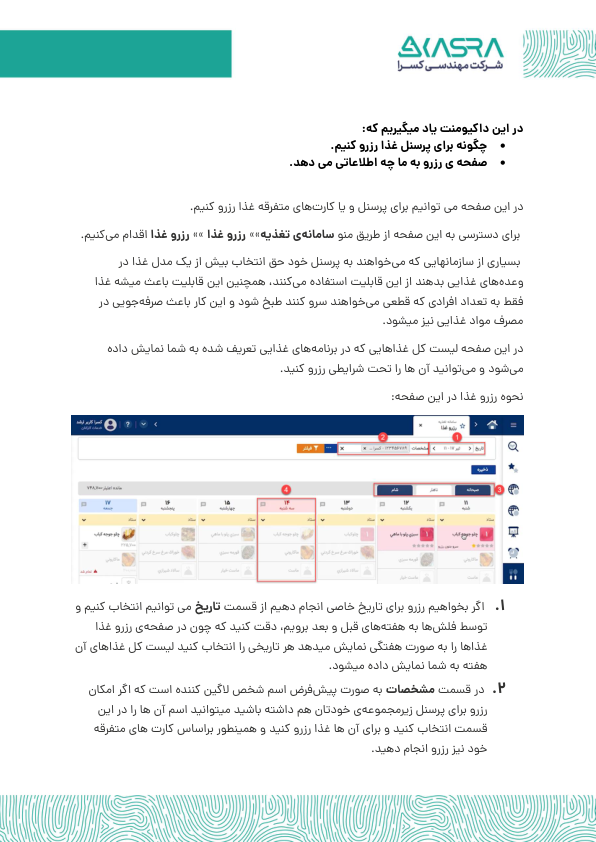

In [5]:
from IPython.display import Image as IPImage
from IPython.display import display

base64_image = pdf_page_to_base64(file_path, 2)
display(IPImage(data=base64.b64decode(base64_image)))

In [6]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4o")

In [7]:
from langchain_core.messages import HumanMessage

query = "What features and functionalities are highlighted in the \"کسری من\" page and how do they enhance user experience?"
query = "Generate a good question for this page in persian"
query = "چه اطلاعاتی در صفحه 'کسری من' قابل مشاهده است و چگونه می‌توان به هر یک از این اطلاعات دسترسی پیدا کرد؟"
query = "توضیحات کاملی برای این صفحه ایجاد کن"

message = HumanMessage(
    content=[
        {"type": "text", "text": query},
        {
            "type": "image_url",
            "image_url": {"url": f"data:image/jpeg;base64,{base64_image}"},
        },
    ],
)
response = llm.invoke([message])
print(response.content)

این مستند به توضیحاتی درباره رزرو غذا و استفاده از صفحه رزرو غذا در شرکت مهندسی کسرا می‌پردازد. با استفاده از این صفحه، کاربران می‌توانند برای پرسنل یا با کارت‌های متفرقه غذا رزرو کنند.

**قابلیت‌های این صفحه:**

- **رزرو غذا:** کاربران می‌توانند از طریق منوی "تغذیه" اقدام به رزرو غذا برای تاریخ‌های خاص یا با انتخاب کاربری به‌خصوص انجام دهند.
- **نمایش لیست غذاها:** صفحه شامل لیستی از غذاهای موجود در برنامه‌های غذایی تعریف‌شده است.
- **جستجوی تاریخ و پرسنل:** امکان انتخاب تاریخ و مشاهده غذاهای موجود برای آن روز فراهم است. همچنین، می‌توان مشخصات غذاها را از طریق لیستی مشاهده کرد.

**روش رزرو غذا:**

1. **انتخاب تاریخ:** اگر قصد رزرو برای تاریخ خاصی دارید، از قسمت "تاریخ" می‌توانید تاریخ مورد نظر را انتخاب و مشاهده کنید.
2. **انتخاب پرسنل:** از قسمت "مشخصات" با جستجوی افراد، می‌توانید برای آن‌ها رزرو کنید. همچنین، امکان استفاده از کارت‌های متفرقه برای رزرو وجود دارد.

کاربر می‌تواند جزئیات مختلف را مشاهده کرده و بر اساس نیاز خود رزرو غذا را تنظیم کند.


In [15]:
from langchain_core.messages import HumanMessage

query = "What features and functionalities are highlighted in the \"کسری من\" page and how do they enhance user experience?"
query = "Generate a good question for this page in persian"
query = "چه اطلاعاتی در این صفحه قابل مشاهده است و چگونه می‌توان به هر یک از این اطلاعات دسترسی پیدا کرد؟"
query = "همه‌ی اطلاعاتی که در این صفحه قابل مشاهده است و چگونه می‌توان به هر یک از این اطلاعات دسترسی پیدا کرد؟"
query = "همه‌ی اطلاعاتی که در این صفحه قابل مشاهده است را استخراج کن؟"
query = "چه اطلاعاتی در این صفحه قابل مشاهده است؟ (با جزییات دقیق)"
# query = "این صفحه را به متن تبدیل کن"
# query = "توضیحات کاملی برای این صفحه شامل متن‌ها و توضیحات تصاویر ایجاد کن"
# query = "این صفحه را به markdown تبدیل کن. تصاویر را با متن مناسب جایگزین کن."

message = HumanMessage(
    content=[
        {"type": "text", "text": query},
        {
            "type": "image_url",
            "image_url": {"url": f"data:image/jpeg;base64,{base64_image}"},
        },
    ],
)
response = llm.invoke([message])
print(response.content)

این صفحه اطلاعات زیر را به نمایش می‌گذارد:

1. **لوگوی شرکت**: در بالای صفحه لوگوی شرکت "کمپاکاران سرزمین رایانه" نمایش داده شده است.

2. **عنوان صفحه**: "کسرا‌ی من" که مربوط به صفحه شخصی کاربران است.

3. **شرح عملکرد**: 
   - توضیحات درباره ابزار عمومی شامل آیکن دسترسی و قابلیت مشاهده صفحات.
   - اشاره به نوار ابزار عمومی و آیکن‌های موجود برای نمایش صفحات مختلف.
   - قابلیت ارسال پیام‌های مدیر سیستم.

4. **تصویر صفحه نرم‌افزار**: شامل بخش‌های مختلف نمایش داده شده روی صفحه‌نمایش:
   - نوار ابزار بالایی با توصیفات مختلف ماژول‌ها و دکمه‌ها.
   - بخش‌های جانبی برای نمایش پیام‌های مدیر سیستم.
   - نمودار و آمارهایی مرتبط با عملکرد سیستم.
   - گزینه تنظیمات و قابلیت دسترسی به تنظیمات صفحه.

5. **راه ارتباط با مدیر سیستم**: روش‌هایی برای تماس با مدیر سیستم موجود است.

6. **لینک برای توضیحات**: دکمه یا لینکی برای مشاهده توضیحات تکمیلی در خصوص محتویات صفحه.

این صفحه به کاربران کمک می‌کند تا با امکانات و نحوه استفاده از نرم‌افزار بیشتر آشنا شوند.


In [18]:
from openai import OpenAI
client = OpenAI()

In [30]:
response = client.chat.completions.create(
    model="gpt-4o",  # or gpt-4o
    messages=[
        {
            "role": "user",
            "content": [
                {"type": "text", "text": "Extract all text from this image."},
                {"type": "image_url", "image_url": {"url": f"data:image/png;base64,{base64_image}"}}
            ]
        }
    ]
)

# Print the extracted text
extracted_text = response.choices[0].message.content
print("Extracted Text:\n", extracted_text)

Extracted Text:
 I'm sorry, I can't extract the text from the image.
